# Charts - Stage Results

This notebook separates out code for generating *stage results* charts. Updates to the chart scripts will be made to this notebook.

In [91]:
import sqlite3
import pandas as pd

In [92]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates

In [93]:
if __name__=='__main__':
    %matplotlib inline

In [94]:
if __name__=='__main__':
    dbname='wrc18.db'
    conn = sqlite3.connect(dbname)

    q="SELECT name FROM sqlite_master WHERE type = 'table';"
    display(pd.read_sql(q,conn))

,name
0,itinerary_event
1,itinerary_legs
2,itinerary_sections
3,itinerary_stages
4,itinerary_controls
5,startlists
6,startlist_classes
7,penalties
8,retirements
9,stagewinners


In [95]:
if __name__=='__main__':
    year=2018
    rc='RC2'
    ss='SS4'
    rally='Sweden'

    typ='stage_times_stage' #stage_times_stage stage_times_overall
    typ='stage_times_overall'

## Stage Results

In [96]:
if __name__=='__main__':
    q='''
    SELECT st.*, sc.name as class, i.code, i.distance, i.name, CAST(REPLACE(code,'SS','') AS INTEGER) snum,
    sl.`driver.code`, sl.`entrant.name`
    FROM {typ} st INNER JOIN itinerary_stages i ON st.stageId = i.stageId
    INNER JOIN startlist_classes sc ON sc.entryid = st.entryId 
    INNER JOIN championship_events ce ON i.eventId=ce.eventId
    INNER JOIN startlists sl ON sl.entryId=sc.entryId
    WHERE sc.name="{rc}" AND ce.`country.name`="{rally}" ORDER BY snum
    '''.format(rc=rc,rally=rally, typ=typ)
    stagerank=pd.read_sql(q,conn)

    stagerank['classrank'] = stagerank.groupby(['snum'])['position'].rank(method='dense').astype(int)

    display(stagerank.head(3))

,diffFirst,diffFirstMs,diffPrev,diffPrevMs,entryId,penaltyTime,penaltyTimeMs,position,stageTime,stageTimeMs,...,totalTimeMs,stageId,class,code,distance,name,snum,driver.code,entrant.name,classrank
0,PT4.1S,4100,PT0.6S,600,1589,PT0S,0,13,PT1M36.8S,96800,...,96800,317,RC2,SS1,1.9,SS1 SSS Karlstad 1,1,TID,Skoda Motorsport,1
1,PT4.2S,4200,PT0.1S,100,1590,PT0S,0,14,PT1M36.9S,96900,...,96900,317,RC2,SS1,1.9,SS1 SSS Karlstad 1,1,VEI,Skoda Motorsport,2
2,PT4.5S,4500,PT0.3S,300,1597,PT0S,0,15,PT1M37.2S,97200,...,97200,317,RC2,SS1,1.9,SS1 SSS Karlstad 1,1,ABB,Kevin Abbring,3


We could further extend the above function to limit the query to return just the rows related to one or more specified stages.

In [97]:
if __name__=='__main__':
    #Get differences in position and time to leader cf previous stage
    stagerank['gainedPos'] = stagerank.groupby(['driver.code'])['position'].diff()<0 
    stagerank['gainedTime'] = stagerank.groupby(['driver.code'])['diffFirstMs'].diff()<0 

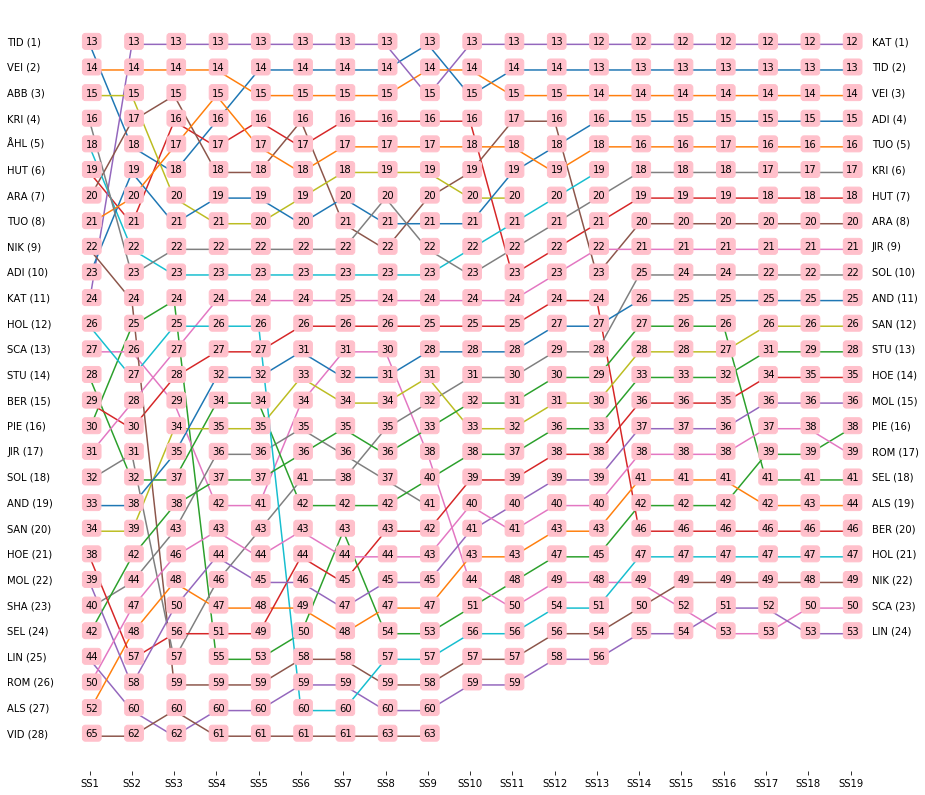

In [98]:
if __name__=='__main__':
    # Group properties
    gc = stagerank
    gcSize = len(gc['entryId'].unique()) #number of entries in class

    rankpos='position'
    #rankpos='classrank'

    # Create plot
    fig, ax = plt.subplots(figsize=(15,gcSize/2))

    #Set blank axes
    ax.xaxis.label.set_visible(False)
    ax.get_yaxis().set_ticklabels([])
    ax.set_yticks([]) 
    ax.set_xticks([]) 

    lhoffset=-1.95
    rhoffset=+0.5

    #labeler
    addlabels = True
    pinklabel= lambda x: int(x['position'])
    #pinklabel= lambda x: int(x['classrank'])
    #pinklabel= lambda x: x['driver.code']

    ylabel = lambda x: x['driver.code']
    ylabel = lambda x: int(x['position'])
    ylabel = lambda x: int(x['classrank'])
    ylabel = lambda x: '{} ({})'.format(x['driver.code'], int(x['classrank']))

    gcSize=10

    # Rally properties
    smin = gc['snum'].min() # min stage number
    smax = gc['snum'].max() # max stage number

    # Define a dummy rank to provide compact ranking display
    # This is primarily for RC1 which we expect to hold the top ranking positions overall
    gc['xrank']= (gc[rankpos]>gcSize)
    gc['xrank']=gc.groupby('snum')['xrank'].cumsum()
    gc['xrank']=gc.apply(lambda row: row[rankpos] if row[rankpos]<=gcSize  else row['xrank'] +gcSize, axis=1)

    #Base plot - line chart showing position of each driver against stages
    gc.groupby('entryId').plot(x='snum',y='xrank',ax=ax,legend=None)

    #Label cars ranked outside the group count - primarily for RC1
    if addlabels:
        for i,d in gc[gc['xrank']>gcSize].iterrows():
            ax.text(d['snum']-0.1, d['xrank'], pinklabel(d),
                    bbox=dict(  boxstyle='round,pad=0.3',color='pink')) #facecolor='none',edgecolor='black',

    #Label driver names at left hand edge
    for i,d in gc[gc['snum']==1].iterrows():
        ax.text(smin+lhoffset, d['xrank'], ylabel(d))

    #Label driver names at right hand edge
    for i,d in gc[gc['snum']==smax].iterrows():
        ax.text(smax+rhoffset, d['xrank'], ylabel(d))

    # Label x-axis stage numbers
    ax.set_xticks(stagerank['snum'].unique()) # choose which x locations to have ticks
    ax.set_xticklabels(stagerank['code'].unique())

    plt.gca().invert_yaxis()

    #Hide outer box
    plt.box(on=None)

In [99]:
#need a view that shows start number on stage versus final position on stage?

In [100]:
if __name__=='__main__':
    q='''
    SELECT il.legDate, il.name AS date, il.startListId, il.status,
        isc.itineraryLegId, isc.itinerarySectionId, isc.name AS section, isc.`order`,
        ist.* FROM championship_events ce 
    JOIN itinerary_event ie ON ce.eventId = ie.eventId 
    JOIN itinerary_legs il ON ie.itineraryId=il.itineraryId
    JOIN itinerary_sections isc ON il.itineraryLegId=isc.itineraryLegId
    JOIN itinerary_stages ist ON ist.`itinerarySections.itinerarySectionId`=isc.itinerarySectionId
    WHERE ce.`country.name`="{rally}" ORDER BY isc.`order`
    '''.format(rally=rally)
    rally_stages = pd.read_sql(q,conn)
    display(rally_stages.head(3))

,legDate,date,startListId,status,itineraryLegId,itinerarySectionId,section,order,code,distance,eventId,name,number,stageId,stageType,status,timingPrecision,itineraryLegId,itinerarySections.itinerarySectionId
0,2018-02-15,Thursday 15 February,74,Completed,53,117,Section 1,1,SS1,1.90,27,SS1 SSS Karlstad 1,1,317,HeadToHeadSuperSpecialStage,Completed,Tenth,53,117
1,2018-02-16,Friday 16 February,78,Completed,54,118,Section 2,2,SS2,21.26,27,SS2 Hof-Finnskog 1,2,299,SpecialStage,Completed,Tenth,54,118
2,2018-02-16,Friday 16 February,78,Completed,54,118,Section 2,2,SS3,24.88,27,SS3 Svullrya 1,3,300,SpecialStage,Completed,Tenth,54,118


In [101]:
if __name__=='__main__':
    display(rally_stages.groupby('section')['number'].max())


section
Section 1     1
Section 2     4
Section 3     8
Section 4    11
Section 5    14
Section 6    16
Section 7    17
Section 8    18
Section 9    19
Name: number, dtype: int64

In [102]:
if __name__=='__main__':
    bottom_offset, top_offset = ax.get_ylim()

In [103]:
if __name__=='__main__':
    #ll=len(stagerank['driver.code'].unique())

    #top_offset and bottom_offset set above

    for i,d in rally_stages.iterrows():
        #Show stage distance
        ax.text(i+1,bottom_offset+0.5,'{}km'.format(d['distance']),
                horizontalalignment='center',fontsize=10, rotation=45)
        #Show stage name
        ax.text(i+1,top_offset-4,'{}'.format(d['name']),
                horizontalalignment='center',fontsize=10, rotation=45)
    #Separate out the separate sections
    for i in rally_stages.groupby('section')['number'].max()[:-1]:
        ax.plot((i+0.5,i+0.5), (top_offset-0.5,bottom_offset+0.5), color='lightgrey', linestyle='dashed')
    fig

### Make  Functions For That...

In [104]:
def dbGetRallyStages(conn, rally):
    q='''
    SELECT il.legDate, il.name AS date, il.startListId, il.status,
        isc.itineraryLegId, isc.itinerarySectionId, isc.name AS section, isc.`order`,
        ist.* FROM championship_events ce 
    JOIN itinerary_event ie ON ce.eventId = ie.eventId 
    JOIN itinerary_legs il ON ie.itineraryId=il.itineraryId
    JOIN itinerary_sections isc ON il.itineraryLegId=isc.itineraryLegId
    JOIN itinerary_stages ist ON ist.`itinerarySections.itinerarySectionId`=isc.itinerarySectionId
    WHERE ce.`country.name`="{rally}" ORDER BY isc.`order`
    '''.format(rally=rally)
    rally_stages = pd.read_sql(q,conn)

    return rally_stages

In [105]:
#stage_times_stage, stage_times_overall

def varasint(cand, retval=''):
    ''' Function to determine if we can cast something as an int.
        If we can, do so and return it, otherwise return retval, or, if retval=='asis', the original value. '''
    retval = int(cand) if (int(cand) if isinstance(cand, str) and cand.isdigit() else False) or isinstance(cand, int) else retval
    if retval=='asis':
        return cand
    return retval

def _qInIntList(items, col, conj='AND', pattern='{}'):
    ''' Generate a SQL clause that tests whether a column value is in a list of values. '''
    items = [varasint(items)] if isinstance(items, (str, int)) else [i for i in [varasint(s) for s in items] if isinstance(i,int)]
    items = " {conj} {col} IN ({s}) ".format( conj=conj, col = col, s=','.join([pattern.format(i) for i in items]) )
 
    return items


def dbGetStageRank(conn, rally, rc, typ='overall', stages=None):
    ''' Function to query the database and return stage ranks either for the stage, or overall.
        The query can be limited to returning the results for one or more stages.
        typ: overall | stage
    '''
    
    stagetyp={'overall':'stage_times_overall', 'stage_times_overall':'stage_times_overall',
              'stage':'stage_times_stage', 'stage_times_stage':'stage_times_stage'} 
    
    stages = '' if stages is None else _qInIntList(stages, 'i.code', pattern="'SS{}'")
     
    q='''
    SELECT st.*, sc.name as class, i.code, i.distance, i.name, CAST(REPLACE(code,'SS','') AS INTEGER) snum,
    sl.`driver.code`, sl.`entrant.name`
    FROM {typ} st INNER JOIN itinerary_stages i ON st.stageId = i.stageId
    INNER JOIN startlist_classes sc ON sc.entryid = st.entryId 
    INNER JOIN championship_events ce ON i.eventId=ce.eventId
    INNER JOIN startlists sl ON sl.entryId=sc.entryId
    WHERE sc.name="{rc}" AND ce.`country.name`="{rally}" {stages} ORDER BY snum, position
    '''.format(rc=rc, rally=rally, typ=stagetyp[typ], stages=stages)
    stagerank=pd.read_sql(q,conn)

    #Ideally, we want this as an int, but if there are NaNs, it breaks
    #Are we making assumptions that this is in postion order?
    stagerank['classrank'] = stagerank.groupby(['snum'])['position'].rank(method='dense').astype(float)

    return stagerank


def stageClassEnrichers(stagerank):
    #Ideally, we want this as an int, but if there are NaNs, it breaks
    stagerank['classrank'] = stagerank.groupby(['snum'])['position'].rank(method='dense').astype(float)
    stagerank['gainedClassPos'] = stagerank.groupby(['driver.code'])['classrank'].diff()<0 
    stagerank['gainedClassLead'] = (stagerank.groupby(['driver.code'])['classrank'].diff()<0 ) & (stagerank['classrank']==1)
    stagerank['classPosDiff'] = stagerank.groupby(['driver.code'])['classrank'].diff().fillna(0)
    stagerank['lostClassLead'] = (stagerank['classrank']!=1) & (stagerank.groupby(['driver.code'])['classrank'].diff() == stagerank['classrank']-1)
    stagerank['retainedClassLead'] = ((stagerank['classrank'] ==1) & (~stagerank['gainedClassLead']) & (stagerank['snum']!=1))
    return stagerank

#https://stackoverflow.com/a/35428677/454773
def winningstreak(x):
    x['winsinarow'] = x.groupby( (x['position'] != 1).cumsum()).cumcount() +  ( (x['position'] != 1).cumsum() == 0).astype(int) 
    return x

def winningstreakleg(x):
    x['legwinsinarow'] = x.groupby( (x['position'] != 1).cumsum()).cumcount() +  ( (x['position'] != 1).cumsum() == 0).astype(int) 
    return x

def _debug_winningstreak(x):
    x['notwin'] = (x['position'] != 1)
    #The notwincumcount creates a new group for each not win
    #So if we have a streak of wins, the notwincumcount groups those together
    x['notwincumcount'] = x['notwin'].cumsum()
    x['startwithawin'] = (x['notwincumcount'] == 0).astype(int)
    #groupby.cumcount  - number each item in each group from 0 to the length of that group - 1.
    x['streakgroupwincount'] = x.groupby( 'notwincumcount' ).cumcount()

    x['winstreak'] = x.groupby( 'notwincumcount' ).cumcount() + x['startwithawin']
    return x

def stageOverallEnrichers(stagerank):
    stagerank['gainedOverallPos'] = stagerank.groupby(['driver.code'])['position'].diff()<0 
    stagerank['gainedOverallLead'] = (stagerank.groupby(['driver.code'])['position'].diff()<0 ) & (stagerank['position']==1)
    stagerank['overallPosDiff'] = stagerank.groupby(['driver.code'])['position'].diff().fillna(0)
    stagerank['lostOverallLead'] = (stagerank['position']!=1) & (stagerank.groupby(['driver.code'])['position'].diff() == stagerank['position']-1)
    stagerank['retainedOverallLead'] = ((stagerank['position'] ==1) & (~stagerank['gainedOverallLead']) & (stagerank['snum']!=1))

    stagerank['stagewin'] = stagerank['position']==1
    stagerank['stagewincount'] = stagerank.groupby(['driver.code'])['stagewin'].cumsum()

    stagerank = stagerank.groupby('driver.code').apply(winningstreak) 


    return stagerank
    
def stageTimeEnrichers(stagerank):
    stagerank['gainedTime'] = stagerank.groupby(['driver.code'])['diffFirstMs'].diff()<=0     
    return stagerank
    

def getEnrichedStageRank(conn,rally,rc='RC1',typ='stage_times_overall',stages=None):
    stagerank = dbGetStageRank(conn,rally,rc,typ, stages)
    stagerank = stageClassEnrichers(stagerank)
    stagerank = stageOverallEnrichers(stagerank)
    stagerank = stageTimeEnrichers(stagerank)
    return stagerank

In [206]:
def dbGetStageStart(conn, rally, rc, stages=None):
    ''' Query the database and return in class stage start and end position.
        Can be limited to return results for one or more stages.
    '''
        
    stages = '' if stages is None else _qInIntList(stages, 'i.code', pattern="'SS{}'")
        
    q='''
    SELECT sp.stageId, sp.entryId, sl.`driver.code`, sp.startDateTime, i.eventId, sc.name,
    CAST(REPLACE(code,'SS','') AS INTEGER) snum, st.position, st.diffFirstMs, st.diffPrevMs
    FROM (SELECT DISTINCT stageId, entryId, startDateTime FROM split_times) AS sp 
    INNER JOIN itinerary_stages i ON sp.stageId = i.stageId
    INNER JOIN startlist_classes sc ON sc.entryid = sp.entryId AND sc.eventId=i.eventId
    INNER JOIN championship_events ce ON i.eventId=ce.eventId
    INNER JOIN startlists sl ON sl.entryId=sc.entryId AND sl.eventId=ce.eventId
    INNER JOIN stage_times_stage st ON st.entryId=sc.entryId AND st.stageId = i.stageId
    WHERE sc.name="{rc}" AND ce.`country.name`="{rally}" {stages} ORDER BY snum, sp.startDateTime
    '''.format(rc=rc, rally=rally, stages=stages)
    stagestart=pd.read_sql(q,conn)
    
    #Ideally, we want this as an int, but if there are NaNs, it breaks
    if not stagestart.empty:
        stagestart['startpos'] = stagestart.groupby(['snum'])['startDateTime'].cumcount()+1
        stagestart['classrank'] = stagestart.groupby(['snum'])['position'].rank(method='dense').astype(float)
        stagestart.drop(['position'], axis=1, inplace=True)
    return stagestart

In [336]:
#https://blog.ouseful.info/2017/03/15/grouping-numbers-that-are-nearly-the-same-casual-clustering/
#https://stackoverflow.com/questions/14783947/grouping-clustering-numbers-in-python/14783998#14783998
def cluster(data, maxgap):
    '''Arrange data into groups where successive elements
       differ by no more than *maxgap*
 
        cluster([1, 6, 9, 100, 102, 105, 109, 134, 139], maxgap=10)
        [[1, 6, 9], [100, 102, 105, 109], [134, 139]]
 
        cluster([1, 6, 9, 99, 100, 102, 105, 134, 139, 141], maxgap=10)
        [[1, 6, 9], [99, 100, 102, 105], [134, 139, 141]]
 
    '''
    data.sort()
    groups = [[data[0]]]
    for x in data[1:]:
        if abs(x - groups[-1][-1]) <= maxgap:
            groups[-1].append(x)
        else:
            groups.append([x])
    return groups

def numclustergroup(x,col,maxgap, cname='clustergroup'):
    x[cname] = (x[col]>=maxgap).cumsum()
    return x

def getBattleGroup(df,groupcol=None,ordercol='position',diffcol='diffPrevMs',
                   window=1000, mingroupsize=3, cname='battlegroup'):
    if ordercol is not None:
        df=df.sort_values(ordercol)
    if not groupcol:
        df = numclustergroup(df,diffcol, window, cname)
        df = df.groupby(cname).filter(lambda x: len(x) >= mingroupsize)
    else:
        df = df.groupby(groupcol).apply(lambda x: numclustergroup(x,diffcol, window,cname))
        df = df.groupby([groupcol,cname]).filter(lambda x: len(x) >= mingroupsize)
    df=df.copy()
    df[cname]=df.groupby(cname).ngroup()
    df['battlepos']=df.groupby(cname)['classrank'].transform('min')
    return df

In [340]:
if __name__=='__main__':
    df = dbGetStageStart(conn, rally, rc, stages=[7,8])
    df=getBattleGroup(df, groupcol='snum', diffcol='diffPrevMs', ordercol=['snum','classrank'], window=1500)
    #df['diffGroupLeadMs']=df.groupby('battlegroup')['diffFirstMs'].transform(lambda x: x - x.min())
    df['diffGroupLeadMs']=df.groupby('battlegroup')['diffPrevMs'].transform(lambda x: x.cumsum()-x.iloc[0])
    #df=getBattleGroup(df, diffcol='diffPrevMs', ordercol=['snum','classrank'], window=500)
    display(df)

,stageId,entryId,startDateTime,eventId,name,snum,diffFirstMs,diffPrevMs,startpos,classrank,battlegroup,battlepos,diffGroupLeadMs
14,304,1641,2018-02-16T15:54:00,27,RC2,7,34100.0,3400.0,15,1.0,1,1.0,0.0
1,304,1590,2018-02-16T15:21:00,27,RC2,7,34900.0,800.0,2,2.0,1,1.0,800.0
0,304,1589,2018-02-16T15:20:00,27,RC2,7,35700.0,800.0,1,3.0,1,1.0,1600.0
3,304,1592,2018-02-16T15:23:00,27,RC2,7,35800.0,100.0,4,4.0,1,1.0,1700.0
6,304,1597,2018-02-16T15:26:00,27,RC2,7,44000.0,2200.0,7,7.0,2,7.0,0.0
9,304,1599,2018-02-16T15:30:00,27,RC2,7,44100.0,100.0,10,8.0,2,7.0,100.0
8,304,1598,2018-02-16T15:29:00,27,RC2,7,44700.0,600.0,9,9.0,2,7.0,700.0
5,304,1594,2018-02-16T15:25:00,27,RC2,7,74500.0,4400.0,6,15.0,5,15.0,0.0
11,304,1601,2018-02-16T15:32:00,27,RC2,7,88700.0,700.0,12,16.0,5,15.0,700.0
20,304,1627,2018-02-16T16:01:00,27,RC2,7,89600.0,900.0,21,17.0,5,15.0,1600.0


In [305]:
def stageAnnotation(ax, stages, rally_stages, prune=True):
    bottom_offset, top_offset = ax.get_ylim()
    stages = rally_stages[rally_stages['code'].isin(stages['code'].unique().tolist())] if prune else rally_stages
    for i,d in stages.iterrows():
        #Show stage distance
        ax.text(i+1,bottom_offset+0.5,'{}km'.format(d['distance']),
                horizontalalignment='center',fontsize=10, rotation=45)
        #Show stage name
        ax.text(i+1,top_offset-4,'{}'.format(d['name']),
                horizontalalignment='center',fontsize=10, rotation=45)
    #Separate out the separate sections
    for i in stages.groupby('section')['number'].max()[:-1]:
        ax.plot((i+0.5,i+0.5), (top_offset-0.5,bottom_offset+0.5), color='lightgrey', linestyle='dashed')

__Note: the following function is out of kilter with the narrative - it includes references to enrichments that are introduced later in the notebook.__

In [107]:
#if there is only one stage, this chart errors
def plotStageProgressionChart(gc, lhoffset=-0.5,rhoffset=0.5,linecolor=None, stageAnnotate=True, prune=True,
                              deltalabels=False, progress=False, winstreak ='winsinarow', rally_stages=None,
                              rankpos='classrank', title=None, elaborate = True, **kwargs):
    ''' rankpos: classrank | position'''
    
    if len(gc['code'].unique())<=1:
        return None, None
    
    gc=gc.copy()
    #For a live stage or for non-finishers, drop the row?
    gc = gc.dropna(subset=['diffFirst'])
    if gc.empty: return None, None
    
    entrySize = len(gc['entryId'].unique()) #number of entries in class

    progress = progress and 'leggainedpos' in gc.columns and 'leggainedtime' in gc.columns
    #rankpos='position'
    #rankpos='classrank'

    # Rally properties
    smin = gc['snum'].min() # min stage number
    smax = gc['snum'].max() # max stage number
    
    # Create plot
    fig, ax = plt.subplots()#figsize=(smax-smin+4,entrySize))

    #Set blank axes
    ax.xaxis.label.set_visible(False)
    ax.get_yaxis().set_ticklabels([])
    ax.set_yticks([]) 
    ax.set_xticks([]) 

    #labeler
    addlabels = True
    pinklabel= lambda x: int(x['position'])
    #pinklabel= lambda x: int(x['classrank'])
    #pinklabel= lambda x: x['driver.code']

    ylabel = lambda x: x['driver.code']
    ylabel = lambda x: int(x['position'])
    ylabel = lambda x: int(x['classrank'])
    ylabel = lambda x: '{} ({})'.format(x['driver.code'], int(x['classrank'])) 
     
    def elaboratelabel(x):
        if x['snum']==1:
            return '{} ({})'.format(x['driver.code'], int(x['classrank']))
        elif x['snum']==smin or not progress:
            txt='{} ({}: {})'
        elif x['leggainedpos'] and x['leggainedtime']:
            txt='{} ($\mathbf{{{}}}$: $\mathbf{{{}}}$)' 
        elif x['leggainedpos']:
            txt='{} ($\mathbf{{{}}}$: {})'
        elif x['leggainedtime']:
            txt='{} ({}: $\mathbf{{{}}}$)'
        else:  txt='{} ({}: {})'
        if x is not None:
            if x['diffFirst'] is not None:
                txt = txt.format(x['driver.code'], int(x['classrank']),x['diffFirst'].replace('PT','+').replace('S',''))
            else: txt = txt.format(x['driver.code'], int(x['classrank']),x['diffFirst'])
        else: txt = 'oops?'
        return txt
    ylabel= lambda x:elaboratelabel(x)
    gcSize=10
    
    ax.set_xlim(smin-0.2,smax+0.2)

    # Define a dummy rank to provide compact ranking display
    # This is primarily for RC1 which we expect to hold the top ranking positions overall
    gc['xrank'] = (gc[rankpos]>gcSize)
    gc['xrank'] = gc.groupby('snum')['xrank'].cumsum()
    gc['xrank'] = gc.apply(lambda row: row[rankpos] if row[rankpos]<=gcSize  else row['xrank'] +gcSize, axis=1)

    #Base plot - line chart showing position of each driver against stages
    gc.groupby('entryId').plot(x='snum',y='xrank',ax=ax,legend=None, color=linecolor)

    #test - lead data
    #for i,d in gc.iterrows():
    for i,d in gc[gc['position']==1].iterrows():
        resp=d[winstreak]#d['lostClassLead']#'1' if d['gainedLead'] else '0'
        ax.text(d['snum'], d['xrank'], resp,
               bbox=dict(  boxstyle='round,pad=0.3',color='lightgrey'),
               horizontalalignment='center')
    
    #Label cars ranked outside the group count - primarily for RC1
    if addlabels:
        for i,d in gc[gc['xrank']>gcSize].iterrows():
            if deltalabels: col='lightgreen' if d['gainedTime'] else 'pink'
            else: col ='pink'
            ax.text(d['snum'], d['xrank'], pinklabel(d),
                    bbox=dict(  boxstyle='round,pad=0.3',color=col),
                    horizontalalignment='center') #facecolor='none',edgecolor='black',

    #Stage time gain / loss indicator
    if deltalabels:
        for i,d in gc.iterrows():
            col='green' if d['gainedTime'] else 'red'
            ax.plot(d['snum'], d['xrank'], 'o', color=col)
    
    
    #Label driver names at left hand edge
    for i,d in gc[gc['snum']==smin].iterrows():
        yl = ylabel(d) if elaborate else d['driver.code']
        ax.text(smin+lhoffset, d['xrank'], yl, horizontalalignment='right')

    #Label driver names at right hand edge
    for i,d in gc[gc['snum']==smax].iterrows():
        yl = ylabel(d) if elaborate else d['driver.code']
        ax.text(smax+rhoffset, d['xrank'], yl, horizontalalignment='left')

    # Label x-axis stage numbers
    ax.set_xticks(gc['snum'].unique()) # choose which x locations to have ticks
    ax.set_xticklabels(gc['code'].unique())

    plt.gca().invert_yaxis()

    if stageAnnotate and not rally_stages.empty: stageAnnotation(ax, gc, rally_stages, prune)
    
    #Hide outer box
    plt.box(on=None)
    
    if title: plt.title(title)
        
    if kwargs is not None and 'filename' in kwargs:
        fig.savefig(kwargs['filename'], bbox_inches='tight')
     
    return fig,ax

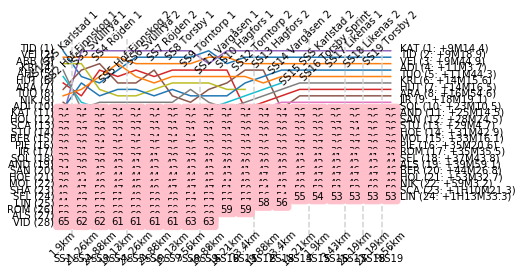

In [108]:
if __name__=='__main__':
    #rally_stages referenced from within a function
    rally_stages = dbGetRallyStages(conn, rally)
    plotStageProgressionChart( dbGetStageRank(conn, rally, rc), rally_stages = rally_stages, filename='TEST.png' );

In [109]:
if __name__=='__main__':
    stagerank[stagerank['driver.code']=='NEU']

In [110]:
if __name__=='__main__':
    stagerank = getEnrichedStageRank(conn,rally)
    stagerank.head(20)

In [111]:
if __name__=='__main__':
    ssdemo = stagerank[stagerank['code'].isin(['SS2','SS3','SS4'])].copy()
    lgp=(ssdemo.groupby('driver.code')['classrank'].agg('first')-ssdemo.groupby('driver.code')['classrank'].agg('last'))>0
    ssdemo['leggainedpos']=ssdemo['driver.code'].map(lgp.to_dict())

    tgp=(ssdemo.groupby('driver.code')['diffFirstMs'].agg('first')-ssdemo.groupby('driver.code')['diffFirstMs'].agg('last'))>=0
    ssdemo['leggainedtime']=ssdemo['driver.code'].map(tgp.to_dict())

In [112]:
def stageLegEnrichers(legStagerank):
    lgp=(legStagerank.groupby('driver.code')['classrank'].agg('first')-legStagerank.groupby('driver.code')['classrank'].agg('last'))>0
    legStagerank['leggainedpos']=legStagerank['driver.code'].map(lgp.to_dict())

    tgp=(legStagerank.groupby('driver.code')['diffFirstMs'].agg('first')-legStagerank.groupby('driver.code')['diffFirstMs'].agg('last'))>=0
    legStagerank['leggainedtime']=legStagerank['driver.code'].map(tgp.to_dict())
    
    legStagerank['legstagewincount'] = legStagerank.groupby(['driver.code'])['stagewin'].cumsum()

    legStagerank = legStagerank.groupby('driver.code').apply(winningstreakleg) 
    return legStagerank


In [113]:
if __name__=='__main__':
    ssdemo = stagerank[stagerank['code'].isin(['SS2','SS3','SS4'])].copy()
    ssdemo = stageLegEnrichers(ssdemo)

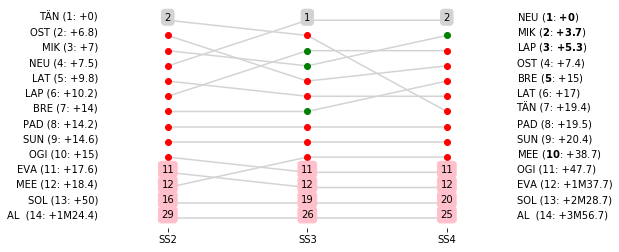

In [114]:
if __name__=='__main__':
    fig, ax = plotStageProgressionChart( ssdemo, linecolor='lightgrey' , deltalabels=True, 
                                        progress=True, stageAnnotate=False);

    #fig, ax = plotStageProgressionChart( stagerank,deltalabels=True );

In [115]:
if __name__=='__main__':
    pass
    #for a in ax.get_xticklabels(): print(a.get_text(), a.get_position())

AttributeError: 'NoneType' object has no attribute 'empty'

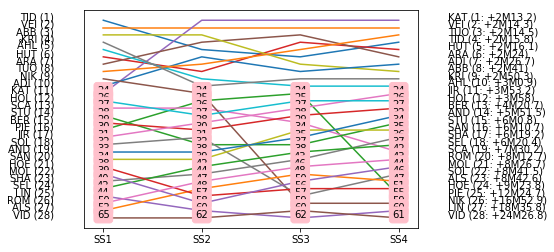

In [116]:
if __name__=='__main__':
    plotStageProgressionChart(gc[gc['snum']<5],prune=False);